# Run an agent based SEIRX simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

import sys
sys.path.insert(0,'..')
sys.path.insert(0,'../nursing_home')
from model_school import SEIRX_school
import viz

## Single model run

### Agents

Agent types used in the simulation with their respective parameters

In [2]:
agent_types = {
        'student':{
            'screening_interval': None,
            'index_probability': 0,
            'mask':False},
        'teacher':{
            'screening_interval': 7,
            'index_probability': 0,
            'mask':True},
        'family_member':{
            'screening_interval': None,
            'index_probability': 0,
            'mask':False}
}

### Measures

Preventive measures implemented to curb the spread of the pandemic

In [3]:
measures = {
    # enables testing and tracing actions (run with testing=False) to simulate
    # unhindered spread of the virus through the nursing home
    'testing':'preventive',
    # test technology and turnover time used for preventive screening
    'preventive_screening_test_type':'same_day_antigen',
    # test technology and turnover time used for diagnostic testing
    'diagnostic_test_type':'two_day_PCR',
    # definition of contact types that will be quarantined in case one
    # of the agents in contact had a positive test result
    'K1_contact_types':['close'],
    # duration (in days) that agents will stay quarantined
    'quarantine_duration':10,
    # interval of a potential follow-up background screen (in days)
    # after a background screen that was initiated by a positive test
    'follow_up_testing_interval':None,
    # whether or not a negative test result "frees" agents from quarantine
    'liberating_testing':False,
    # modification of the transmission risk by ventilation 
    # (1 = no modification, 0.5 = risk is reduced by 50%)
    'ventilation_modification':1
}


### Model parameters

In [11]:
model_params = {
    # mean and variance of a Weibull distribution characterizing the
    # time between transmission and becoming infectious (in days)
    'exposure_duration':[5.0, 1.9], # literature values
    # mean and variance of a Weibull distribution characterizing the
    # time between transmission and showing symptoms in clinical courses
    # of the infection (in days)
    'time_until_symptoms':[6.4, 0.8], # literature values
    # mean and variance of a Weibull distribution characterizing the
    # time between transmission and ceasing to be infectious (in days)
    'infection_duration':[10.91, 3.95], # literature values
    # modification of the transmission risk in subclinical courses
    'subclinical_modifier':0.6, 
    # base transmission risk of a contact of type "close"
    'base_risk':0.2, # artificially high
    # efficiency of masks (surgical), reducing the transmission risk
    # (exhale) if the source wears a mask and/or the reception risk 
    # (inhale), if the target (also) wears a mask
    'mask_filter_efficiency':{'exhale':0.5, 'inhale':0.7}, # literature values
    # modifiers of the base_risk for transmissions of contact type close
    # if the contact type is "intermediate", "far" or "very var"
    'infection_risk_contact_type_weights':\
        {'very_far':0, 'far':0.75, 'intermediate':0.85,'close':1}, # calibrated
    # modification of the transmission and reception risk depending on 
    # the age of the transmitting and receiving agents. At age >= 18,
    # the modifier = 1. A slope of -0.02 means that for every year an
    # agent is younger than 18, the transmission and reception risk is
    # reduced by 2%
    'age_transmission_discount':{'slope':-0.02, 'intercept':1}, # calibrated
    # modification of the probability to have a symptomatic course,
    # depending on the age of the agent. At age >= 18, agents have an
    # empirically observed probability of ~80% to have a symptomatic course.
    # A slope of -0.03 means that for every year an agent is younger than
    # 18, the probability to have a symptomatic course is reduced by 3%.
    'age_symptom_discount':\
        {'slope':-0.02868, 'intercept':0.7954411542069012}, # empirical values
    # agent group from which the index case is drawn
    'index_case':'teacher',
    # verbosity level (can be 0, 1, 2) that prints increasingly detailed 
    # information about the simulation
    'verbosity':0
}

In [12]:
school_name = 'test_school_primary'
# interaction network of students, teachers and household members
G = nx.readwrite.gpickle.read_gpickle('../data/school/{}.bz2'\
                                      .format(school_name))
# number of steps (days) the simulation will run
N_steps = 50

# fixed seed of the simulation, using the same seed repeats the 
# same simulation if the same parameters are chosen. Setting 
# seed = None corresponds to a random initialization.
seed = 3

model = SEIRX_school(G, model_params['verbosity'], 
      base_transmission_risk = model_params['base_risk'], 
      testing = measures['testing'],
      exposure_duration = model_params['exposure_duration'],
      time_until_symptoms = model_params['time_until_symptoms'],
      infection_duration = model_params['infection_duration'],
      quarantine_duration = measures['quarantine_duration'],
      subclinical_modifier = model_params['subclinical_modifier'], 
      infection_risk_contact_type_weights = \
            model_params['infection_risk_contact_type_weights'], 
      K1_contact_types = measures['K1_contact_types'],
      diagnostic_test_type = measures['diagnostic_test_type'],
      preventive_screening_test_type = \
            measures['preventive_screening_test_type'],
      follow_up_testing_interval = \
            measures['follow_up_testing_interval'],
      liberating_testing = measures['liberating_testing'],
      index_case = model_params['index_case'],
      agent_types = agent_types, 
      age_transmission_risk_discount = \
            model_params['age_transmission_discount'],
      age_symptom_discount = model_params['age_symptom_discount'],
      mask_filter_efficiency = model_params['mask_filter_efficiency'],
      transmission_risk_ventilation_modifier = \
            measures['ventilation_modification'],
      seed=seed)

for i in range(N_steps):
    if model_params['verbosity'] > 0: print('*** step {} ***'.format(i+1))
    model.step()

### Visualise time-series of student infections

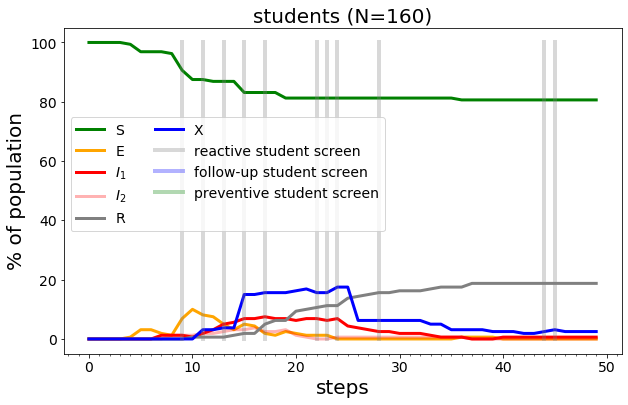

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
viz.draw_infection_timeline(model, 'student', ax)

### Visualise time-series of teacher infections

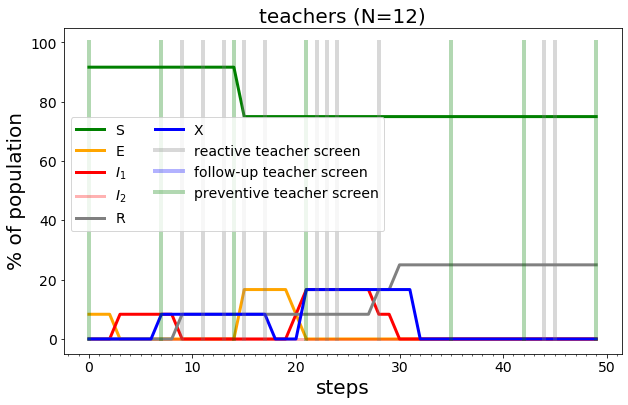

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
viz.draw_infection_timeline(model, 'teacher', ax)

### Have a peek at the raw data

In [10]:
data = model.datacollector.get_model_vars_dataframe()
data.head(5)

,E_student,I_student,I_asymptomatic_student,I_symptomatic_student,R_student,X_student,E_teacher,I_teacher,I_asymptomatic_teacher,I_symptomatic_teacher,...,screen_teachers_follow_up,screen_teachers_preventive,screen_family_members_reactive,screen_family_members_follow_up,screen_family_members_preventive,N_diagnostic_tests,N_preventive_screening_tests,undetected_infections,predetected_infections,pending_test_infections
0,0,0,0,0.0,0,0,1,0,0,0.0,...,False,True,False,False,False,0,12,0,0,0
1,0,0,0,0.0,0,0,1,0,0,0.0,...,False,False,False,False,False,0,12,0,0,0
2,0,0,0,0.0,0,0,1,0,0,0.0,...,False,False,False,False,False,0,12,0,0,0
3,0,0,0,0.0,0,0,0,1,0,1.0,...,False,False,False,False,False,0,12,0,0,0
4,0,0,0,0.0,0,0,0,1,0,1.0,...,False,False,False,False,False,0,12,0,0,0
